# MNIST Conditional DCGAN

This exercise uses conditional DCGAN architecture to generate specific MNIST digit image. This is a continuation from previous exercise using DCGAN without condition. Previously,G and D only want to learn about the distribution of MNIST i.e. P(x) but now we want to specify the label y. In other words, we condition the distribution on the label, P(x|y). In other words, when given a specific label, we want G to generate that particular digit, and want D to recognise this digit rather than any other digit. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

print("Pytorch version:",torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Pytorch version: 0.4.0


# Data

The MNIST data is PIL image range from 0 to 1. We'll transform them to range [-1, 1]. The image size is 28x28 grayscale but are first resized to 32x32, therefore each minibatch will have shape (128, 1, 32, 32)

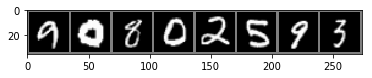

    9     0     8     0     2     5     9     3


In [2]:
batch_size = 128
labels_dim = 10

transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show some images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
print(' '.join('%5s' % labels[j].numpy() for j in range(8)))

# One Hot Encoding
Instead of just using single variable for label as input to the networks, we encode it using one hot encoding. Therefore, for every label say label=2, this will be converted into array of size 10 i.e. [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ]

In [3]:
def one_hot_encode(y, label=1.0):
    one_hot = torch.Tensor(len(y),labels_dim,device=device).fill_(0.0).to(device)
    one_hot.scatter_(1, y.view(-1,1), label)
    return one_hot.view(len(y), labels_dim, 1, 1)

#print(labels.shape)
#print(one_hot_encode(labels).shape)

# Generator Network

We want the tensors from layer output to have following shapes:

input: (batch_size, 100, 1, 1)
deconv1: (batch_size, 512, 4, 4).
deconv2: (batch_size, 256, 8, 8)
deconv3: (batch_size, 128, 16, 16)
deconv4: (batch_size, 1, 32, 32)

As mentioned earlier, we now take labels with shape (batch_size, 10, 1, 1) as additional input. Therefore, we create an additional transpose convolutional to transform it into size that matches the output shape from first transpose conv layer i.e (batch_size, ngf*8, 7, 7). We then concatenate the two tensors together. 


In [11]:
nz = 100

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
class Generator(nn.Module):
    def __init__(self, nc=1, ngf=64):
        super(Generator, self).__init__()
        # input shape : (n, nz, 1, 1)
        self.conv_t_1 =nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=True)
        self.bn_1 = nn.BatchNorm2d(ngf*8)
        
        # this layer take labels as input
        self.conv_t_1l =nn.ConvTranspose2d(labels_dim, ngf*8, 4, 1, 0, bias=True)
        self.bn_1l = nn.BatchNorm2d(ngf*8)        
        
        # concatenate
        
        # input shape : (n, ngf*8, 4, 4)
        self.conv_t_2 =nn.ConvTranspose2d(ngf*8*2, ngf*4, 4, 2, 1, bias=True)
        self.bn_2 = nn.BatchNorm2d(ngf*4)
        
        # input shape : (n, ngf*4, 8, 8)
        self.conv_t_3 =nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=True)
        self.bn_3 = nn.BatchNorm2d(ngf*2)
                
        # tensor shape : (n, ngf*4, 16, 16)
        self.conv_t_4 =nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias=True)
        
        # tensor shape : (n, ngf*4, 16, 16)
    
    def forward(self, z, label):
        z_out = F.relu(self.bn_1(self.conv_t_1(z)))
        label_out = F.relu(self.bn_1l(self.conv_t_1l(label)))
        x = torch.cat([z_out, label_out], 1)
        x = F.relu(self.bn_2(self.conv_t_2(x)))
        x = F.relu(self.bn_3(self.conv_t_3(x)))
        # use tanh to squeeze the output to within [-1, +1]
        x = F.tanh(self.conv_t_4(x))
        
        return x
    
netG = Generator().to(device)
netG.apply(weights_init)


Generator(
  (conv_t_1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_1l): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn_1l): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_2): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

# Discriminator

Similar to Generator, we create an additional transpose conv layer to upscale the label vectors to (batch_size, ndf, 14, 14) that matches the output of first conv layer.

In [12]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        
        # input shape : (n, nc, 32, 32)
        self.conv2d_1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=True)
        
        # label input (n, 10, 1, 1)
        # use transpose conv to upscale it to (n, ndf, 16, 16)
        self.conv2d_1l = nn.ConvTranspose2d(labels_dim, ndf, 16, 1, 0, bias=True)
        
        # concatenate to ndf*4
        # tensor shape : (n, ndf, 16, 16)
        self.conv2d_2 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=True)
        self.bn_2 = nn.BatchNorm2d(ndf*4)
        
        # tensor shape : (n, ndf, 8, 8)
        self.conv2d_3 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=True)
        self.bn_3 = nn.BatchNorm2d(ndf*8)
        
        # tensor shape : (n, ndf*2, 4, 4)
        self.conv2d_4 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=True)
        

    def forward(self, img, label):
        img = F.leaky_relu(self.conv2d_1(img), 0.2)
        y = F.leaky_relu(self.conv2d_1l(label), 0.2)
        x = torch.cat([y, img], 1)
        
        x = F.leaky_relu(self.bn_2(self.conv2d_2(x)), 0.2)
        x = F.leaky_relu(self.bn_3(self.conv2d_3(x)), 0.2)
        x = F.sigmoid(self.conv2d_4(x))
        return x.view(-1,1).squeeze(1)
    
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (conv2d_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2d_1l): ConvTranspose2d(10, 64, kernel_size=(16, 16), stride=(1, 1))
  (conv2d_2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

# Objective Function and Training

Here we use the objective (loss) function from vanilla GAN that aims to minimise Jensen-Shanon divergence. In other words, to minimise the probability distribution between the real image and fake generated image. We'll first fix the G and update D; then fix D and update G.

For discriminator loss, say p is output of D() regardless of output:
- When input is real, we want to maximise log(p) or minimise -log(p)
- When input is fake, we want to minimise log(p) or minimise -log(1-p)
- Now say y is the label (0=fake, 1=real(, we can therefore combine the losses to -(y log p +(1-y) log(1-p)) which is the binary cross entropy loss

We can either do backprop after each input (real and fake), or do backprop on the sum of losses

For generator loss, input to D is always fake, and if we want to fool G by maximizing log(p) which is the same as D loss function with real input.

## Optimizer

We use Adam optimizer which incorporate momentum for faster gradient descent and seperate learning rate based for individual weight

In [13]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

display_size = 10
fixed_noise = torch.randn(display_size, nz, 1, 1, device=device)
fixed_labels = one_hot_encode(torch.tensor(range(labels_dim),dtype=torch.long, device=device),1)

print(torch.tensor(range(labels_dim,),dtype=torch.long).shape)
print(fixed_labels.shape)

torch.Size([10])
torch.Size([10, 10, 1, 1])


[0] Loss_D: 1.7149  Loss_G: 9.4916


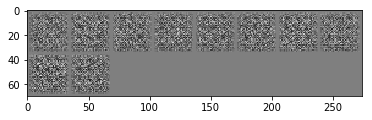

[1] Loss_D: 0.9165  Loss_G: 1.6834


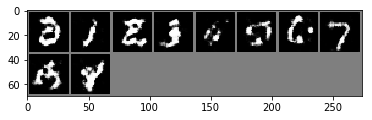

[2] Loss_D: 0.8557  Loss_G: 3.3117


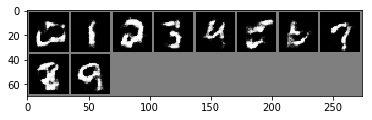

[3] Loss_D: 0.9464  Loss_G: 1.7971


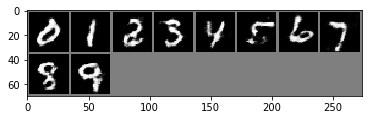

[4] Loss_D: 0.9965  Loss_G: 1.1710


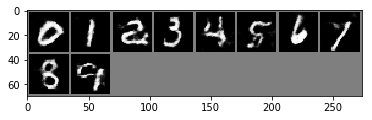

[5] Loss_D: 0.9194  Loss_G: 2.1864


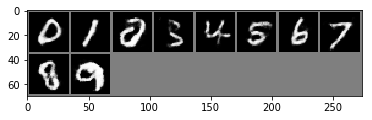

[6] Loss_D: 0.9712  Loss_G: 1.2051


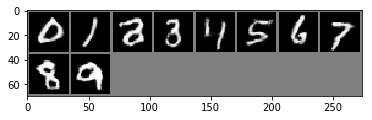

[7] Loss_D: 0.9794  Loss_G: 2.2332


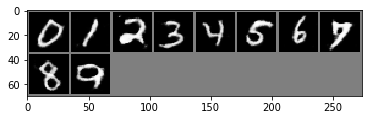

[8] Loss_D: 0.8849  Loss_G: 2.6264


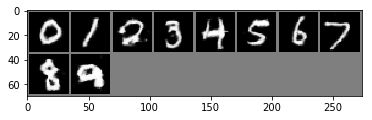

[9] Loss_D: 0.7218  Loss_G: 1.9043


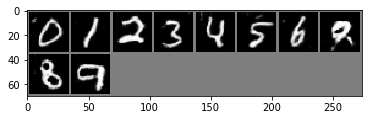

[10] Loss_D: 0.8179  Loss_G: 1.0432


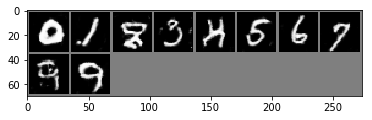

[11] Loss_D: 0.6558  Loss_G: 2.7064


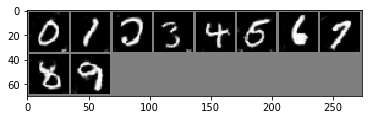

[12] Loss_D: 0.6184  Loss_G: 2.7841


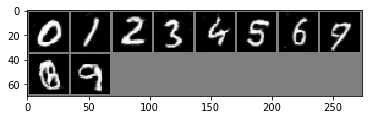

[13] Loss_D: 0.7334  Loss_G: 3.0214


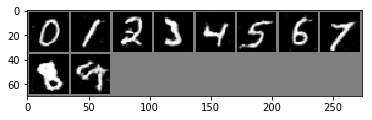

[14] Loss_D: 0.6353  Loss_G: 2.4417


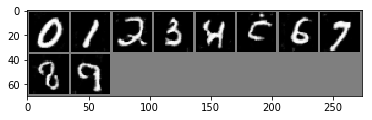

[15] Loss_D: 0.6973  Loss_G: 3.1094


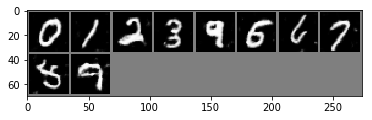

[16] Loss_D: 0.6194  Loss_G: 2.4881


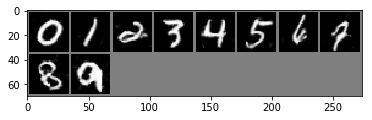

[17] Loss_D: 0.6954  Loss_G: 2.2275


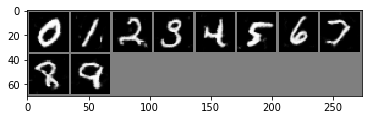

[18] Loss_D: 0.5937  Loss_G: 3.3100


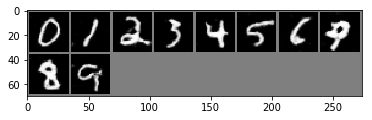

[19] Loss_D: 0.7569  Loss_G: 3.0533


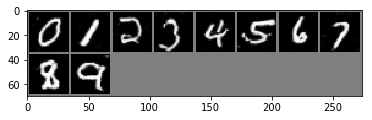

[20] Loss_D: 0.6118  Loss_G: 2.9077


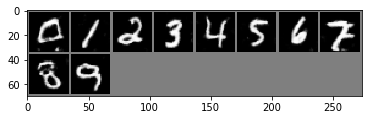

[21] Loss_D: 0.8393  Loss_G: 3.6671


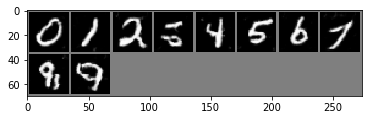

[22] Loss_D: 0.5695  Loss_G: 3.9824


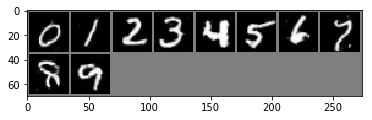

[23] Loss_D: 0.5806  Loss_G: 4.0660


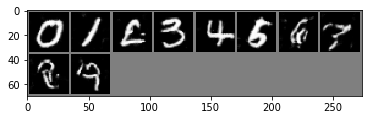

[24] Loss_D: 0.6036  Loss_G: 3.5648


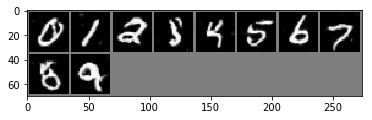

[25] Loss_D: 0.6933  Loss_G: 2.5572


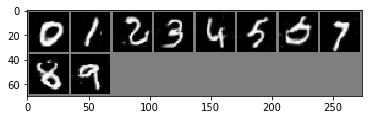

[26] Loss_D: 0.8199  Loss_G: 4.1748


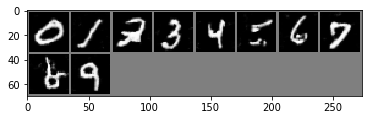

[27] Loss_D: 0.5424  Loss_G: 3.5760


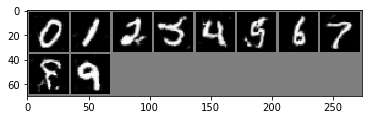

[28] Loss_D: 0.5783  Loss_G: 3.3267


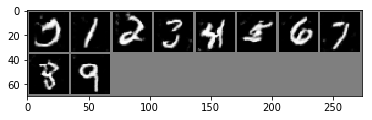

[29] Loss_D: 0.5433  Loss_G: 3.6509


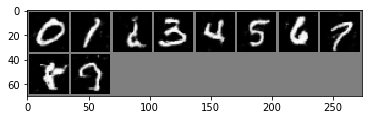

[30] Loss_D: 0.5655  Loss_G: 2.9642


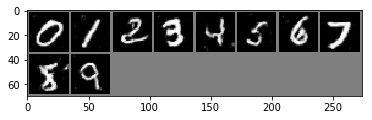

[31] Loss_D: 0.7064  Loss_G: 3.3044


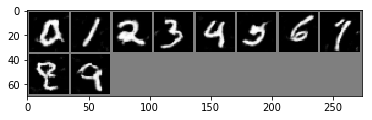

[32] Loss_D: 0.5374  Loss_G: 3.8480


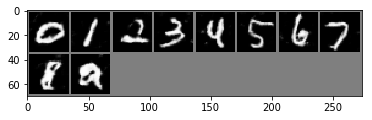

[33] Loss_D: 0.5684  Loss_G: 2.9992


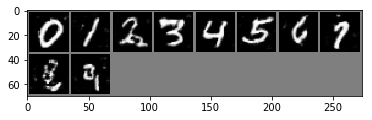

[34] Loss_D: 0.5626  Loss_G: 3.4849


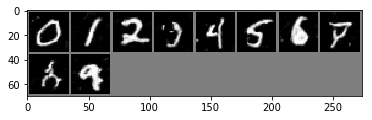

[35] Loss_D: 0.5393  Loss_G: 3.6932


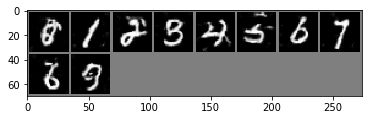

[36] Loss_D: 0.5272  Loss_G: 4.3254


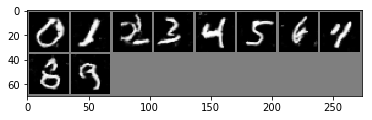

[37] Loss_D: 0.5280  Loss_G: 4.4353


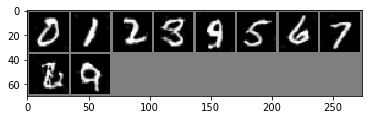

[38] Loss_D: 0.5530  Loss_G: 4.5704


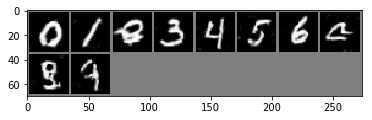

[39] Loss_D: 0.8090  Loss_G: 3.9804


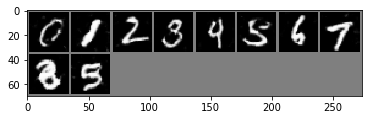

[40] Loss_D: 0.7918  Loss_G: 2.7594


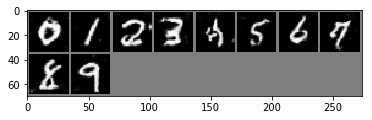

[41] Loss_D: 0.5730  Loss_G: 4.5758


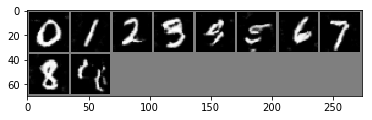

[42] Loss_D: 0.5475  Loss_G: 3.5996


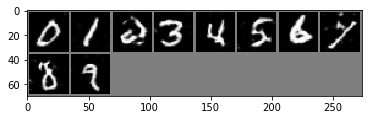

[43] Loss_D: 0.5299  Loss_G: 4.0379


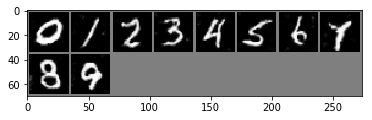

[44] Loss_D: 0.5408  Loss_G: 3.5004


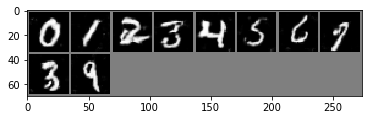

[45] Loss_D: 0.5425  Loss_G: 3.9356


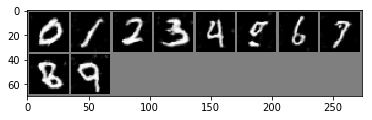

[46] Loss_D: 0.5414  Loss_G: 4.4920


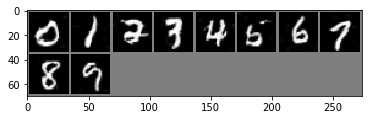

[47] Loss_D: 0.5323  Loss_G: 4.4393


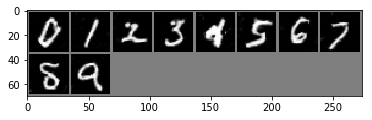

[48] Loss_D: 0.5323  Loss_G: 3.7312


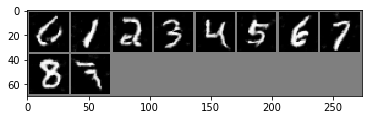

[49] Loss_D: 0.5503  Loss_G: 4.7297


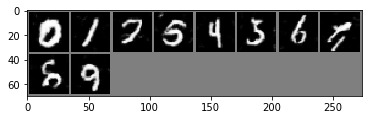

In [14]:
n_epoch = 50
n_show = 10000
n_save = 50

for epoch in range(n_epoch):
    for i, data in enumerate(trainloader, 0):
        # data[0] is images, data[1] is labels
        # Discriminator - real
        netD.zero_grad()
        
        real_data = data[0].to(device)
        labels = data[1].to(device)
        batch_size = real_data.size(0)
        
        # This is a trick to use random number instead of 1.0 or 1.0. This is because at the begining, G won't
        # be generating realistic image and D might be able to discriminate it everytime and
        # leaving it with 0 zero to backprop.However, this didn't work well for this project.
        # https://github.com/soumith/ganhacks       
        real_labels = torch.full((batch_size,), 0.8, device=device)
        g_real_labels = torch.full((batch_size,), 0.8, device=device)
        fake_labels = torch.full((batch_size,), 0.0, device=device)                
        
        
        one_hot_input_labels = one_hot_encode(labels, 1)
        output = netD(real_data, one_hot_input_labels)
        loss_d_real = criterion(output, real_labels)
        loss_d_real.backward()
        
        # Discriminator - fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        # generate random label
        rand_labels = torch.randint(0, labels_dim, (batch_size,), dtype=torch.long, device=device)
        one_hot_rand_labels = one_hot_encode(rand_labels, 1)

        fake_data = netG(noise, one_hot_rand_labels)
        
        # detach G's output i.e. fake_data from D so G does not get backprop
        output = netD(fake_data.detach(), one_hot_rand_labels)
        loss_d_fake = criterion(output, fake_labels)
        loss_d_fake.backward()        
        
        # Discriminator - update 2 backprop
        optimizerD.step()
        
        loss_d_total = loss_d_real + loss_d_fake
        #loss_d_total.backward()
        # Generator
        
        netG.zero_grad()
        output = netD(fake_data, one_hot_rand_labels)
        loss_g = criterion(output, g_real_labels)
        loss_g.backward()
        
        optimizerG.step()
        
        
        # show image
        if i%n_show == 0:
            print('[%d] Loss_D: %.4f  Loss_G: %.4f'%(epoch, loss_d_total.item(), loss_g.item()))
            test_imgs = netG(fixed_noise, fixed_labels)
            imshow(torchvision.utils.make_grid(test_imgs[0:10].detach().cpu()))
            
        if i%n_save == 0:
            torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % ('./models', epoch))
            torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % ('./models', epoch))